In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('gps_data_outlier_preprocessed.csv', index_col=0)

In [9]:
df.head()

,time,lat,lon,gps_time,driver_hash,fraud,gps_delta,gps_distance,gps_speed,gps_accel,...,tm_trip_max_speed,tm_trip_mean_accel,tm_trip_median_accel,tm_trip_max_accel,sin_hours,sin_min,sin_sec,cos_hours,cos_min,cos_sec
0,2020-11-10 03:08:12,55.473589,37.705870,2020-11-10 03:08:12,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.707107,0.743145,9.510565e-01,7.071068e-01,0.669131,3.090170e-01
1,2020-11-10 03:42:48,55.473589,37.705870,2020-11-10 03:42:48,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,0.707107,-0.951057,-9.510565e-01,7.071068e-01,-0.309017,3.090170e-01
2,2020-11-10 06:38:31,55.473589,37.705870,2020-11-10 06:38:30,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,0.00000,0.000000,0.00000,0.000000,1.000000,-0.743145,1.224647e-16,6.123234e-17,-0.669131,-1.000000e+00
3,2020-11-10 06:54:36,55.473589,37.705870,2020-11-10 06:54:36,-9218579406240981296,-1,0.0,0.0,0.000000,0.00000,...,4259.41581,266.233163,0.00029,1419.780337,1.000000,-0.587785,-5.877853e-01,6.123234e-17,0.809017,-8.090170e-01
4,2020-11-10 06:56:45,55.473520,37.705963,2020-11-10 06:56:45,-9218579406240981296,-1,129.0,9.6,0.074798,0.00058,...,4259.41581,266.233163,0.00029,1419.780337,1.000000,-0.406737,-1.000000e+00,6.123234e-17,0.913545,-1.836970e-16


In [10]:
df.columns

Index(['time', 'lat', 'lon', 'gps_time', 'driver_hash', 'fraud', 'gps_delta',
       'gps_distance', 'gps_speed', 'gps_accel', 'gps_outlier', 'gps_staying',
       'tm_delta', 'tm_distance', 'tm_speed', 'tm_accel', 'tm_outlier',
       'tm_staying', 'is_trip_start', 'is_buisness_day', 'is_rush_hour',
       'gps_trip_duration', 'gps_trip_mean_timedelta',
       'gps_trip_median_timedelta', 'gps_trip_max_timedelta',
       'gps_trip_cum_timedelta', 'gps_trip_length', 'gps_trip_mean_dist',
       'gps_trip_median_dist', 'gps_trip_max_dist', 'gps_trip_cum_dist',
       'gps_trip_mean_speed', 'gps_trip_median_speed', 'gps_trip_max_speed',
       'gps_trip_mean_accel', 'gps_trip_median_accel', 'gps_trip_max_accel',
       'tm_trip_duration', 'tm_trip_mean_timedelta',
       'tm_trip_median_timedelta', 'tm_trip_max_timedelta',
       'tm_trip_cum_timedelta', 'tm_trip_length', 'tm_trip_mean_dist',
       'tm_trip_median_dist', 'tm_trip_max_dist', 'tm_trip_cum_dist',
       'tm_trip_mean_speed

In [11]:
features = [
    'gps_delta',
       'gps_distance', 'gps_speed', 'gps_accel', 'gps_outlier', 'gps_staying',
       'tm_delta', 'tm_distance', 'tm_speed', 'tm_accel', 'tm_outlier',
       'tm_staying', 'is_trip_start', 'is_buisness_day', 'is_rush_hour',
       'gps_trip_duration', 'gps_trip_mean_timedelta',
       'gps_trip_median_timedelta', 'gps_trip_max_timedelta',
       'gps_trip_cum_timedelta', 'gps_trip_length', 'gps_trip_mean_dist',
       'gps_trip_median_dist', 'gps_trip_max_dist', 'gps_trip_cum_dist',
       'gps_trip_mean_speed', 'gps_trip_median_speed', 'gps_trip_max_speed',
       'gps_trip_mean_accel', 'gps_trip_median_accel', 'gps_trip_max_accel',
       'tm_trip_duration', 'tm_trip_mean_timedelta',
       'tm_trip_median_timedelta', 'tm_trip_max_timedelta',
       'tm_trip_cum_timedelta', 'tm_trip_length', 'tm_trip_mean_dist',
       'tm_trip_median_dist', 'tm_trip_max_dist', 'tm_trip_cum_dist',
       'tm_trip_mean_speed', 'tm_trip_median_speed', 'tm_trip_max_speed',
       'tm_trip_mean_accel', 'tm_trip_median_accel', 'tm_trip_max_accel',
       'sin_hours', 'sin_min', 'sin_sec', 'cos_hours', 'cos_min', 'cos_sec'
]

In [12]:
len(features)

53

In [14]:
X = df[features]

In [22]:
models = {i: KMeans(n_clusters=i, max_iter=100000, random_state=42) for i in range(2, 11)}

In [24]:
for i, model in models.items():
    model.fit(X)
    print(f'Fit model {i}')

Fit model 2
Fit model 3
Fit model 4
Fit model 5
Fit model 6
Fit model 7
Fit model 8
Fit model 9
Fit model 10


In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

## 2 кластера

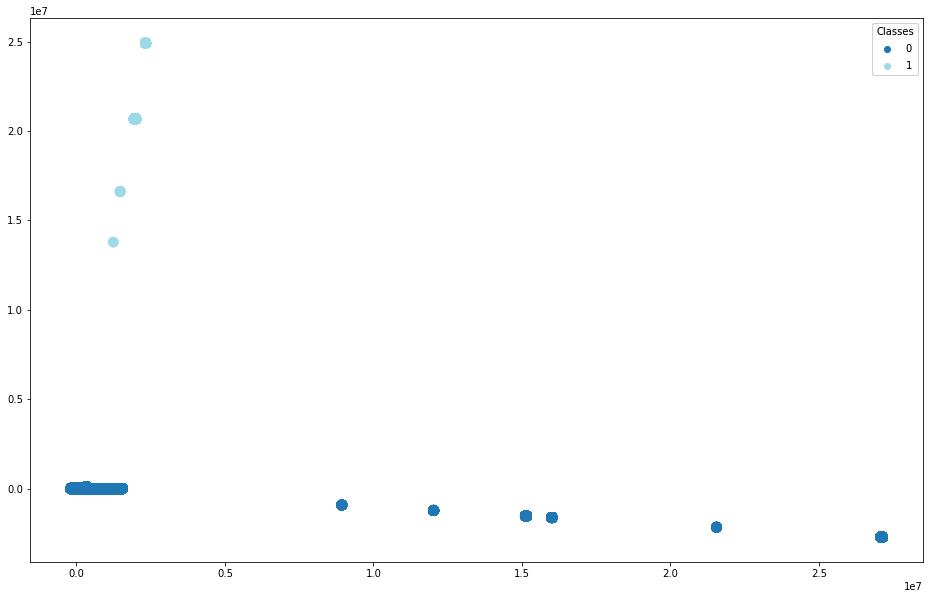

In [39]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[2]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [40]:
y = pd.Series(y)
y.value_counts()

0    5017790
1       2721
dtype: int64

In [51]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.12%
Процент фрода в кластере 1: 3.79%


## 3 кластера

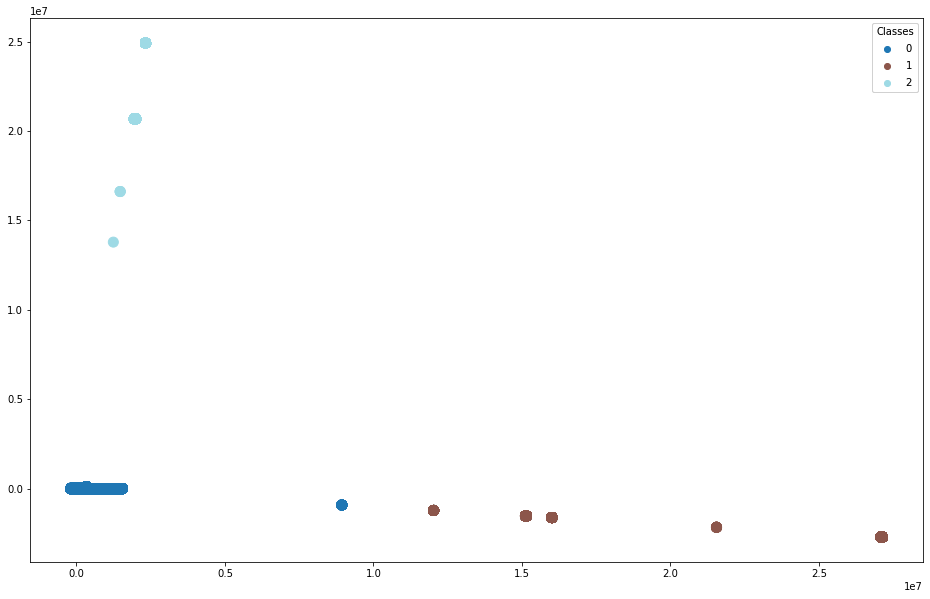

In [87]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[3]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [53]:
y = pd.Series(y)
y.value_counts()

0    5014850
1       2940
2       2721
dtype: int64

In [54]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.10%
Процент фрода в кластере 2: 3.79%
Процент фрода в кластере 1: 40.85%


## 4 кластера

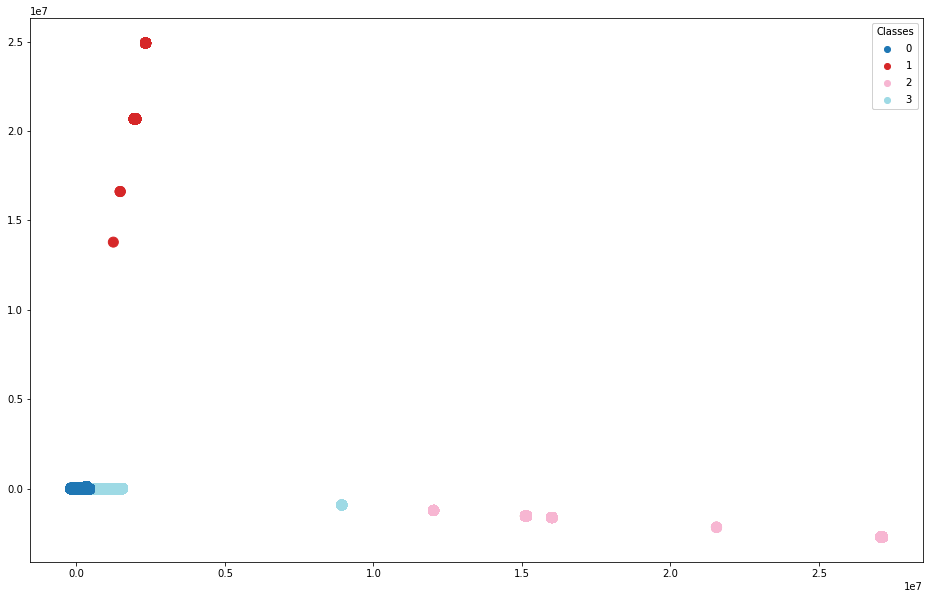

In [55]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[4]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [58]:
y = pd.Series(y)
y.value_counts()

0    4921383
3      93467
2       2940
1       2721
dtype: int64

In [66]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.14%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 3: 0.00%
Процент фрода в кластере 2: 40.85%


## 5 кластеров

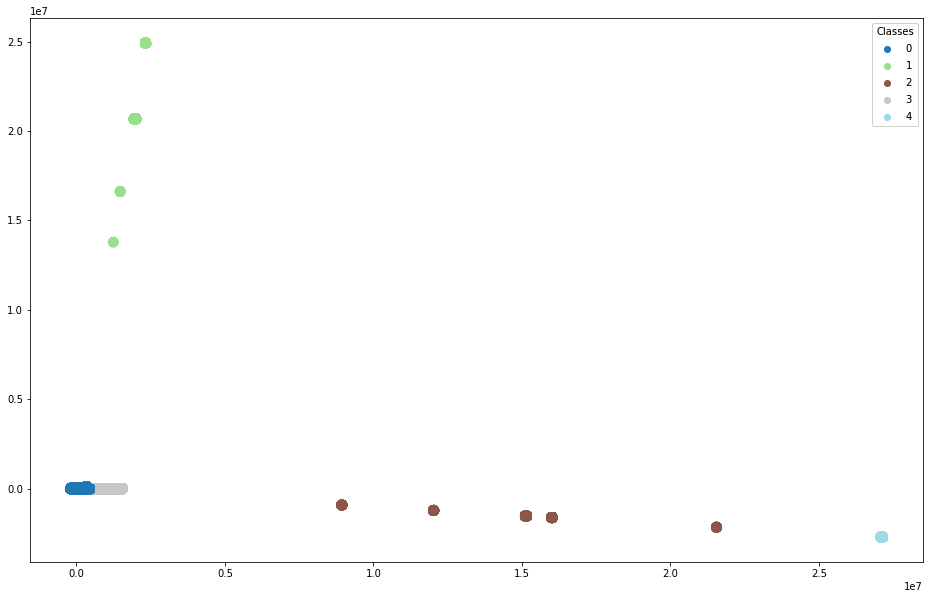

In [67]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[5]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [68]:
y = pd.Series(y)
y.value_counts()

0    4921309
3      93513
1       2721
2       2083
4        885
dtype: int64

In [69]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.14%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 2: 15.17%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%


## 6 кластеров

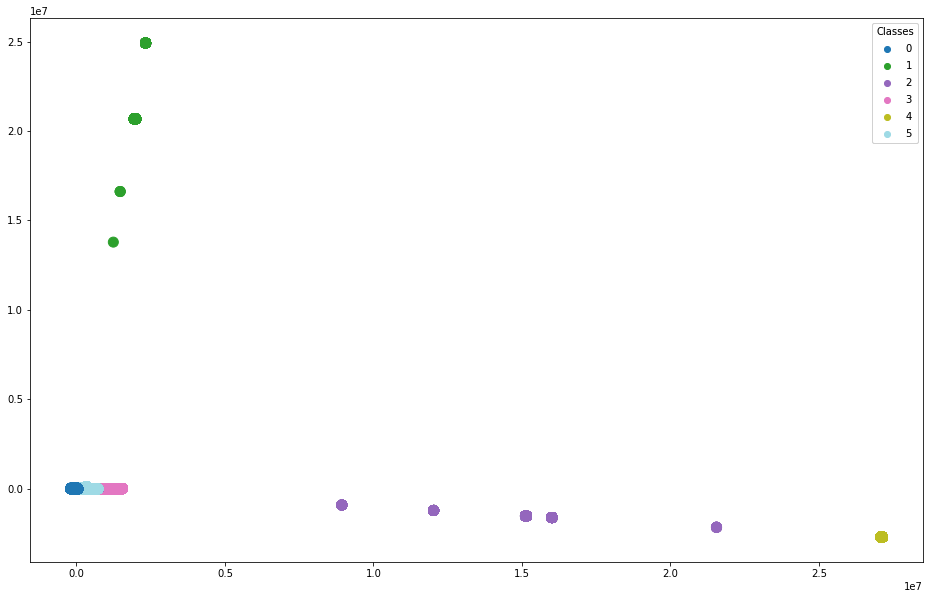

In [70]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[6]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [71]:
y = pd.Series(y)
y.value_counts()

0    3871276
5    1067987
3      75559
1       2721
2       2083
4        885
dtype: int64

In [72]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.51%
Процент фрода в кластере 5: 0.74%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 2: 15.17%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%


## 7 кластеров

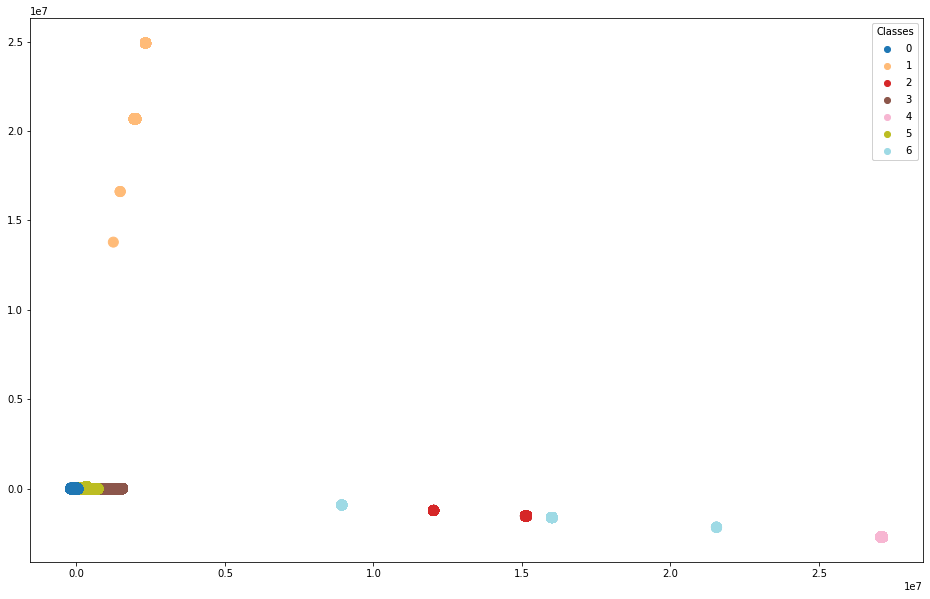

In [74]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[7]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [75]:
y = pd.Series(y)
y.value_counts()

0    3871276
5    1067987
3      75559
1       2721
2       1739
4        885
6        344
dtype: int64

In [76]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 0: 2.51%
Процент фрода в кластере 5: 0.74%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 6: 91.86%
Процент фрода в кластере 2: 0.00%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%


## 8 кластеров

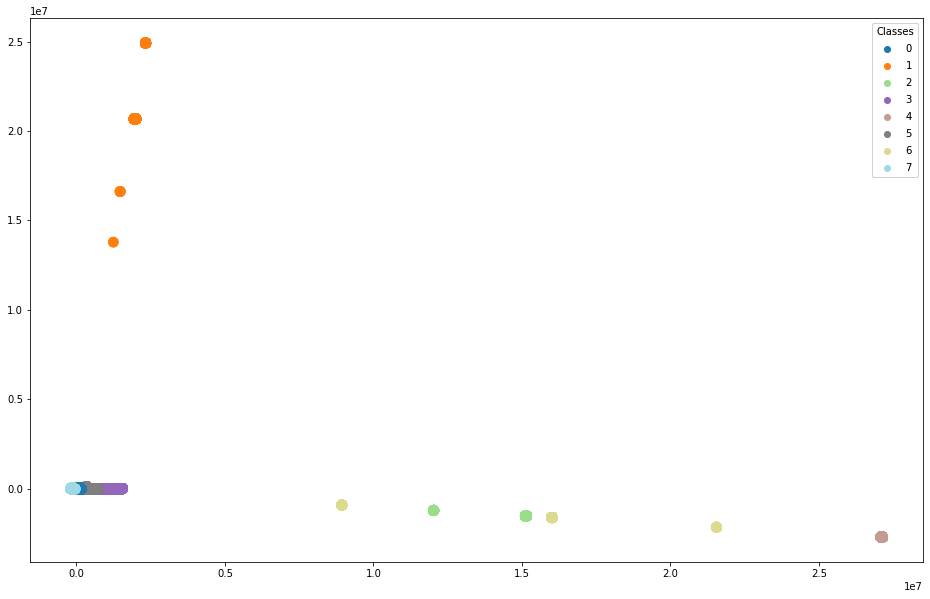

In [77]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[8]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [78]:
y = pd.Series(y)
y.value_counts()

7    2706884
0    1631610
5     600769
3      75559
1       2721
2       1739
4        885
6        344
dtype: int64

In [79]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 7: 3.16%
Процент фрода в кластере 0: 1.21%
Процент фрода в кластере 5: 0.00%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 6: 91.86%
Процент фрода в кластере 2: 0.00%
Процент фрода в кластере 4: 100.00%
Процент фрода в кластере 3: 0.00%


## 9 кластеров

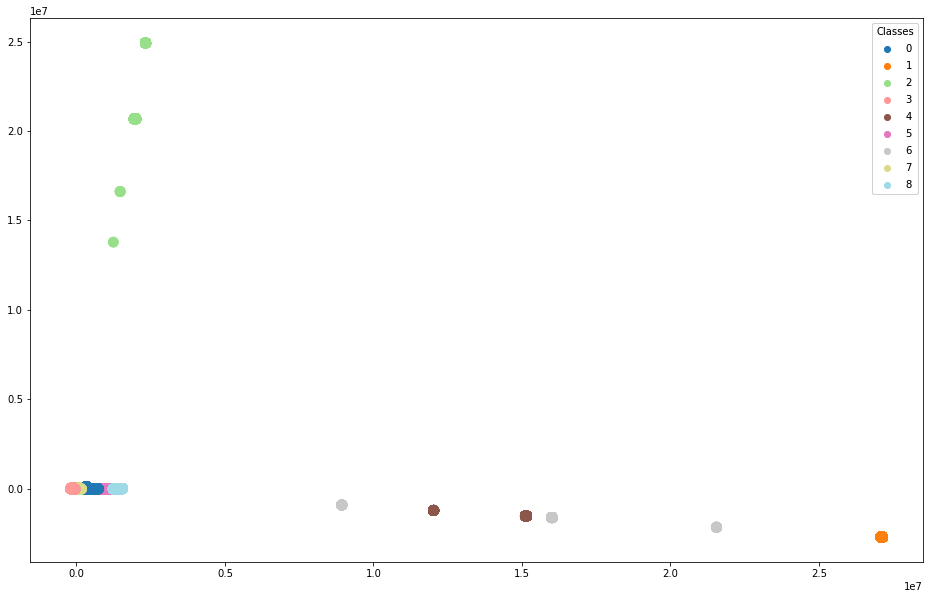

In [80]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[9]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [81]:
y = pd.Series(y)
y.value_counts()

3    2741578
7    1602908
0     594777
8      38200
5      37359
2       2721
4       1739
1        885
6        344
dtype: int64

In [82]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 3: 3.13%
Процент фрода в кластере 7: 1.21%
Процент фрода в кластере 0: 0.00%
Процент фрода в кластере 2: 3.79%
Процент фрода в кластере 6: 91.86%
Процент фрода в кластере 4: 0.00%
Процент фрода в кластере 1: 100.00%
Процент фрода в кластере 5: 0.00%
Процент фрода в кластере 8: 0.00%


## 10 кластеров

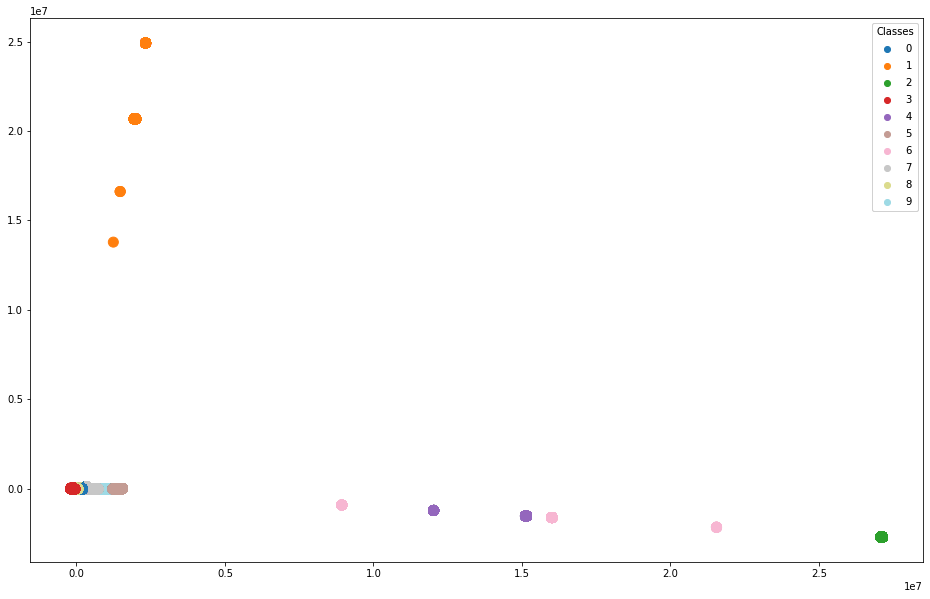

In [83]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

model = models[10]
y = model.predict(X)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, cmap='tab20')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)
plt.show()

In [84]:
y = pd.Series(y)
y.value_counts()

3    2583494
8    1598265
0     501873
7     255631
5      38201
9      37358
1       2721
4       1739
2        885
6        344
dtype: int64

In [85]:
cluster_df = pd.DataFrame({'fraud': df.fraud.copy(), 'cluster': y})
for i in cluster_df.cluster.unique():
    group = cluster_df[cluster_df.cluster == i]
    fraud = group.fraud.value_counts()[1] if 1 in group.fraud.value_counts().index else 0
    print(f'Процент фрода в кластере {i}: {fraud / len(group) * 100:.2f}%')

Процент фрода в кластере 3: 3.28%
Процент фрода в кластере 8: 1.29%
Процент фрода в кластере 0: 0.00%
Процент фрода в кластере 7: 0.00%
Процент фрода в кластере 1: 3.79%
Процент фрода в кластере 6: 91.86%
Процент фрода в кластере 4: 0.00%
Процент фрода в кластере 2: 100.00%
Процент фрода в кластере 9: 0.00%
Процент фрода в кластере 5: 0.00%
